#### **Density Profile Measurements**:

Notebook for calculation of 2D and 3D density profiles of galaxies, dark matter, and gas.

##### **Load Catalog Data:**

Load catalog data in manner used throughout this [tutorial](https://www.tng-project.org/data/docs/scripts/).
* Clone [illustris_python](https://github.com/illustristng/illustris_python) repo which has nice functions for loading halos
* Download group, snapshot, and offset [catalogs](https://www.tng-project.org/data/downloads/TNG100-1/) for a particular snapshot (66 in this notebook)

Follow naming conventions for folder hierarchy as used throughout tutorial linked above (replacing with simulation name and snapshot index when appropriate) and then all of the loadHalo, loadSubhalo, etc. functions from the illustris_python repo should work.

In [21]:
import numpy as np
import illustris_python as il
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import seaborn as sns
import h5py
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology as colossus_cosmo
from colossus.halo import concentration
import scipy

sns.set(style = "ticks")
pi = np.pi

%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'

basePath = './TNG-100_3/outputs/'
snapshot_ind = 66

# Load header file and halo group catalog
header = il.groupcat.loadHeader(basePath, snapshot_ind)

halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_R_Mean200']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)

# Get and print some cosmological info
boxsize = header['BoxSize'] # kpc/h


redshift = header['Redshift']
H = cosmo.H(redshift)
cosmo_col = colossus_cosmo.setCosmology('planck15');
conv_fac = 100/(H.value*1000) # Multiplicative factor to convert from kpc/h to Mpc

# Define box boundary vector in Mpc (for period bcs)
box_bounds = boxsize*conv_fac*np.ones(3)


print("Snapshot Num: "+str(snapshot_ind))
print("Snapshot Boxsize: "+str(boxsize)+" [kpc/h]")
print("Snapshot Redshift: "+str(redshift))
print("Total Number of Halos in Snapshot: "+str(halo_grp['count']))

Snapshot Num: 66
Snapshot Boxsize: 75000.0 [kpc/h]
Snapshot Redshift: 0.524565820433923
Total Number of Halos in Snapshot: 138061


##### **Load a Halo:**

Load a particular dark matter halo and plot the gas and dark matter distribution within the halo. All positions are converted to Mpc.

<Figure size 432x288 with 0 Axes>

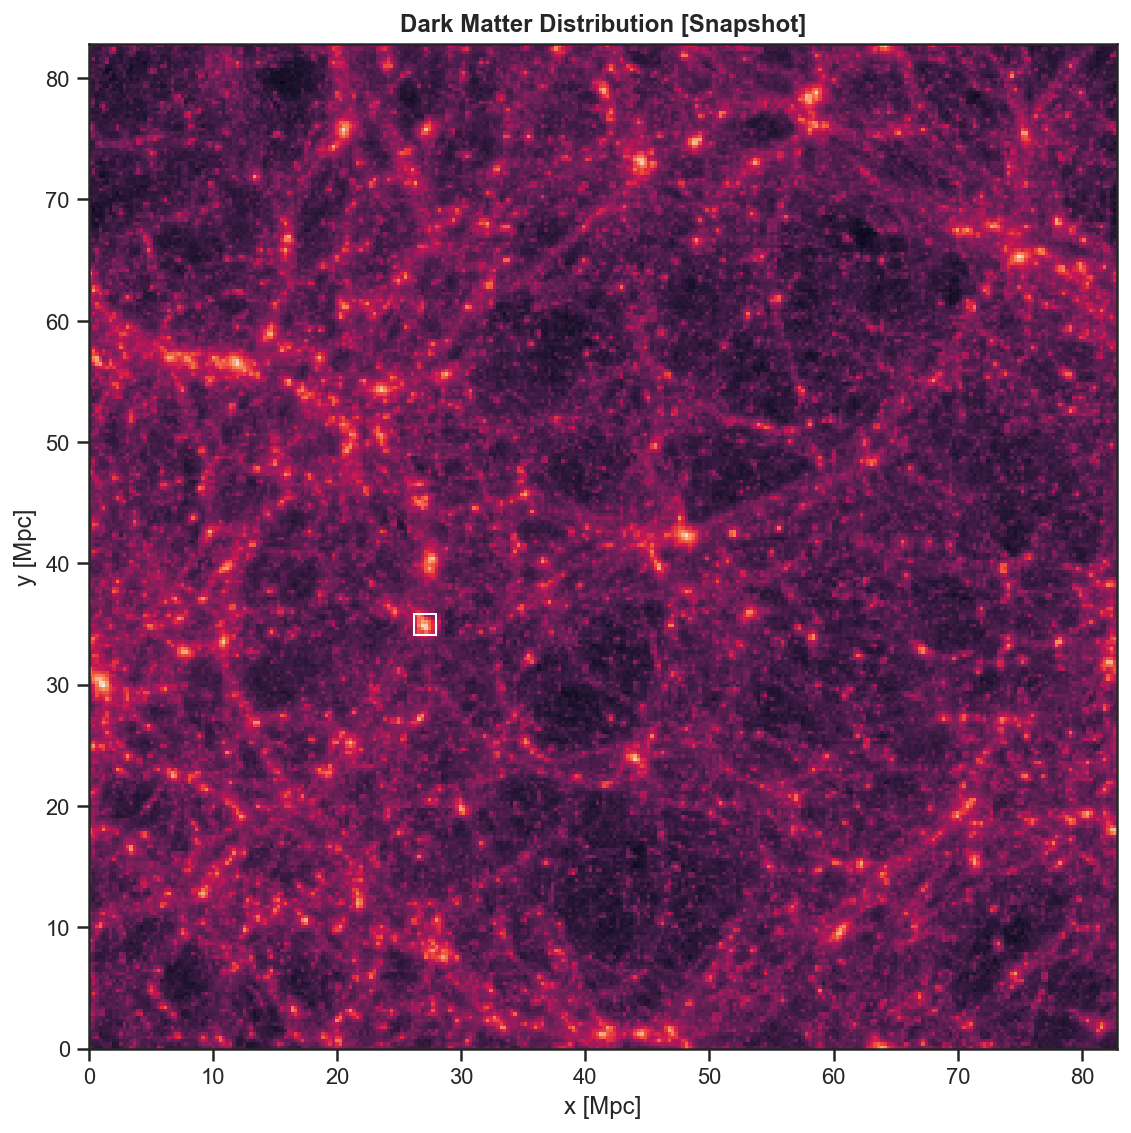

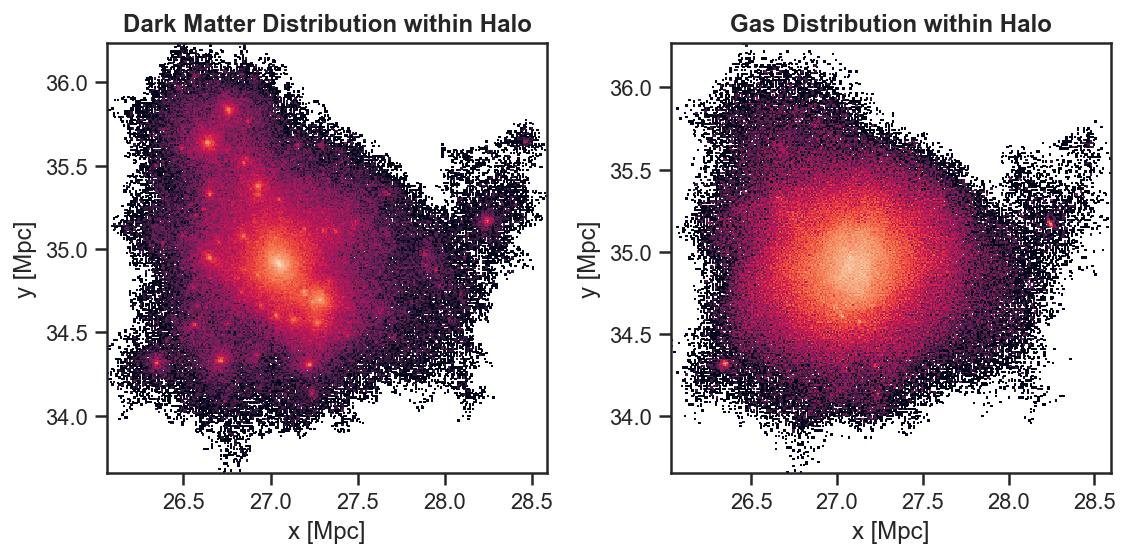

In [3]:
halo_ind = 3 # Which halo to analyze

assert(halo_ind >= 0 and halo_ind < halo_grp['count']) 

halo_cm = halo_grp['GroupCM'][halo_ind]*conv_fac
halo_gas = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind, 'gas')
halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind,'dm')

dm_pos = il.snapshot.loadSubset(basePath, snapshot_ind, 'dm', ['Coordinates'])*conv_fac
halo_gas_pos = halo_gas['Coordinates']*conv_fac
halo_dm_pos = halo_dm['Coordinates']*conv_fac
halo_R_Mean200 = halo_grp['Group_R_Mean200'][snapshot_ind]*conv_fac

# Plot dark matter distribution
plt.figure(1)
plt.figure(figsize=(8, 8))
plt.hist2d(dm_pos[:,0], dm_pos[:,1], norm=colors.LogNorm(), bins=300)

# Plot box around selected halo
rec = plt.Rectangle((halo_cm[0]-1.5*halo_R_Mean200, halo_cm[1]-1.5*halo_R_Mean200), 
                    3*halo_R_Mean200, 3*halo_R_Mean200, ec="white", fill=None)
plt.gca().add_patch(rec)

plt.xlim(np.array([0,75000])*conv_fac)
plt.ylim(np.array([0,75000])*conv_fac)
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
plt.title("Dark Matter Distribution [Snapshot]", fontweight="bold")
plt.tight_layout()

# Plot gas and dark matter particle distributions within second halo
plt.figure(2)
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist2d(halo_dm_pos[:,0], halo_dm_pos[:,1], norm=colors.LogNorm(), bins=300)
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
plt.title("Dark Matter Distribution within Halo", fontweight="bold")

plt.subplot(1,2,2)
plt.hist2d(halo_gas_pos[:,0], halo_gas_pos[:,1], norm=colors.LogNorm(), bins=300)
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
plt.title("Gas Distribution within Halo", fontweight="bold")

plt.tight_layout()

##### **Compute Halo Density Profile:**

Compute 2D and 3D denstiy profiles of the dark matter and gas within a halo.

In [28]:
class HALO_PROFILE(object):
    """
    Class for storing a halo profiles of an object
        
    Fill in later

    """
    def __init__(self, halo_grp, halo_ind):
        
        self.halo_cm = halo_grp['GroupCM'][halo_ind]*conv_fac
        self._halo_grp = halo_grp
        self.halo_ind = halo_ind
        self.halo_M_Crit200 = self._halo_grp['Group_M_Crit200'][self.halo_ind]*10**10*conv_fac
        
        # Load gas and dark mattter halos
        halo_gas = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind, 'gas')
        halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind,'dm')

        self.halo_gas_pos = halo_gas['Coordinates']*conv_fac
        self.halo_dm_pos = halo_dm['Coordinates']*conv_fac
        self.R_mean_200 = halo_grp['Group_R_Mean200'][snapshot_ind]*conv_fac

        
        n_bins = 300
        self.dm_2d_profile = self.compute_2D_density_profile(self.halo_dm_pos[:, 0:2], n_bins)
        self.dm_3d_profile = self.compute_3D_density_profile(self.halo_dm_pos, n_bins)
        self.gas_2d_profile = self.compute_2D_density_profile(self.halo_gas_pos[:, 0:2], n_bins)
        self.gas_3d_profile = self.compute_3D_density_profile(self.halo_gas_pos, n_bins)
        
    
    def compute_2D_density_profile(self, positions, n_res):
        """
        Inputs:
        positions (n*2 array): x and y positions of particles
        n_res (int): number of radial bins to average over

        Returns:
        average_bin_radius (array): average radial position of each density bin (Mpc)
        sigma (array): density of each radial bin (Counts/Mpc^2)
        """

        # Verify input has correct shape
        assert(len(positions.T==2))

        dev = np.abs(positions-self.halo_cm[0:2]) # Deviation from cm
        dev = np.where(dev > 0.5 * box_bounds[0:2], 
                       dev-box_bounds[0:2], dev) # Account for period boundary condtions
        r = np.linalg.norm(dev, axis=1)

        counts, r_edges = np.histogram(r, n_res)
        dr = r_edges[1]-r_edges[0]

        average_bin_radius = 1/2*(r_edges[1:]+r_edges[0:-1])
        dA = 2*np.pi*average_bin_radius*dr

        sigma = counts/dA

        return average_bin_radius, sigma


    def compute_3D_density_profile(self, positions, n_res):
        """
        Inputs:
        positions (n*3 array): x, y, and z positions of particles
        n_res (int): number of radial bins to average over

        Returns:
        average_bin_radius (array): average radial position of each density bin (Mpc)
        rho (array): density of each radial bin (Counts/Mpc^3)
        """

        # Verify input has correct shape
        assert(len(positions.T==3))

        dev = np.abs(positions-self.halo_cm) # Deviation from cm
        dev = np.where(dev > 0.5 * box_bounds, 
                       dev - box_bounds, dev) # Account for period boundary condtions
        r = np.linalg.norm(dev, axis=1)

        counts, r_edges = np.histogram(r, n_res)
        dr = r_edges[1]-r_edges[0]

        average_bin_radius = 1/2*(r_edges[1:]+r_edges[0:-1])
        dV = 4*np.pi*average_bin_radius**2*dr

        rho = counts/dV

        return average_bin_radius, rho

    
    def compute_nfw_profile(self, r):
        
        # Compute NFW Profile
       
        cvir = 5
        z = redshift
        p_nfw = profile_nfw.NFWProfile(M = self.halo_M_Crit200/conv_fac, 
                                       c = cvir, z = z, mdef = '200c')
        rho_nfw = p_nfw.density(r)
        
        return rho_nfw
    
    def recompute_profiles(self, n_bins):
        
        # Compute profiles for specified nbins
        self.dm_2d_profile = self.compute_2D_density_profile(self.halo_dm_pos[:, 0:2], n_bins)
        self.dm_3d_profile = self.compute_3D_density_profile(self.halo_dm_pos, n_bins)
        self.gas_2d_profile = self.compute_2D_density_profile(self.halo_gas_pos[:, 0:2], n_bins)
        self.gas_3d_profile = self.compute_3D_density_profile(self.halo_gas_pos, n_bins)

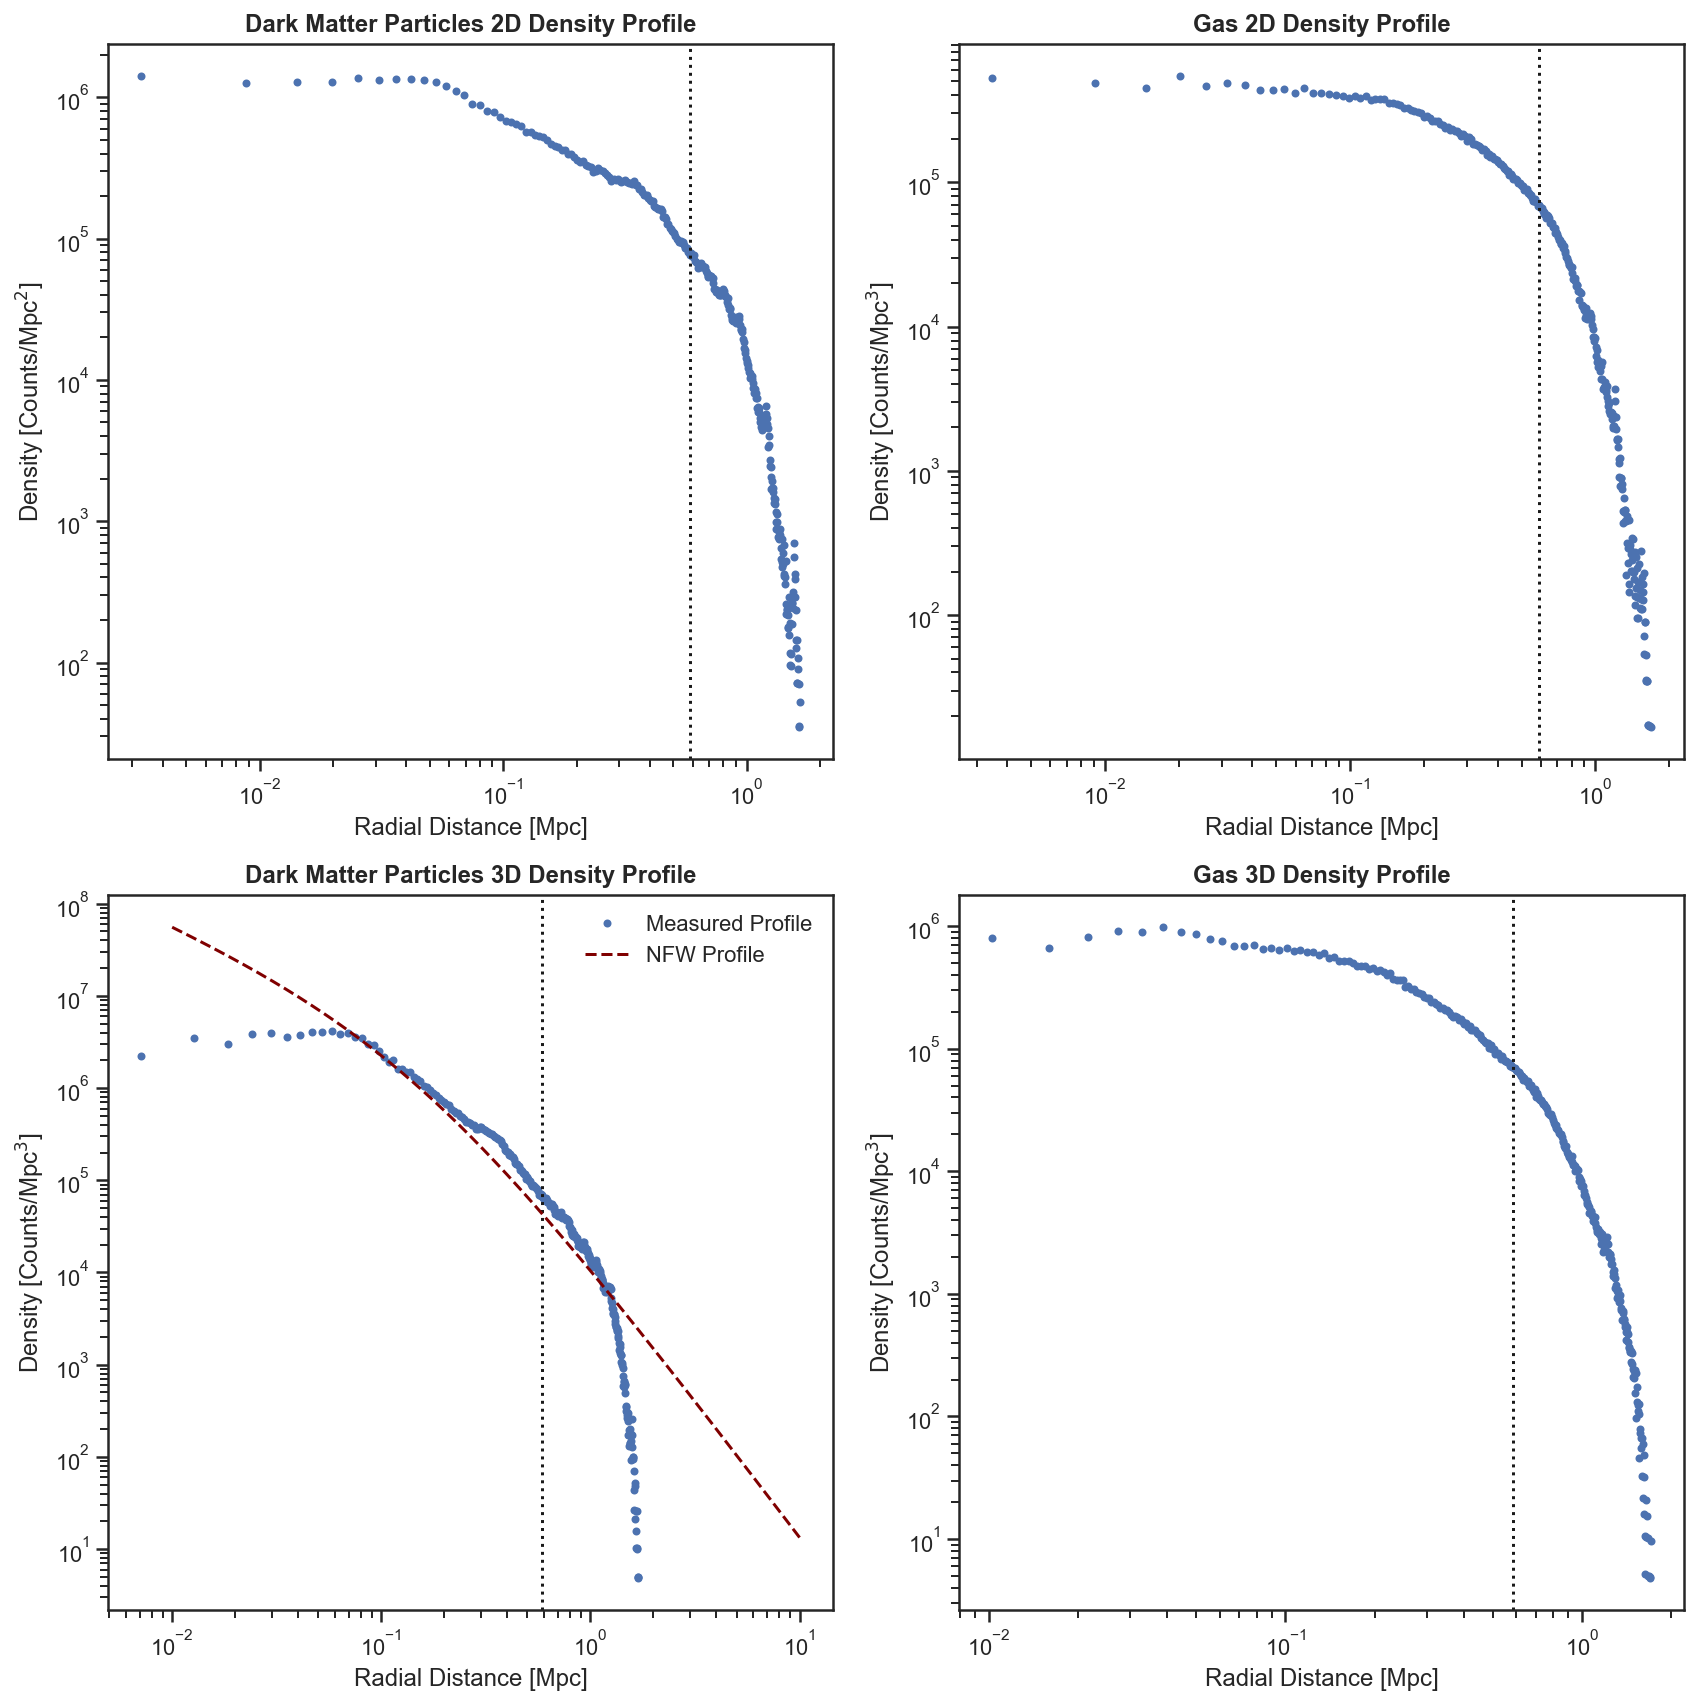

In [5]:
# Example of plotting profiles for a halo
halo = HALO_PROFILE(halo_grp, halo_ind=3)

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.plot(halo.dm_2d_profile[0], halo.dm_2d_profile[1],'.')
plt.title("Dark Matter Particles 2D Density Profile", fontweight="bold")
plt.axvline(halo.R_mean_200, color="k", linestyle=":")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel("Density [Counts/Mpc$^2$]")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,2)
plt.plot(halo.gas_2d_profile[0], halo.gas_2d_profile[1],'.')
plt.axvline(halo.R_mean_200, color="k", linestyle=":")
plt.title("Gas 2D Density Profile", fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel(r"Density [Counts/Mpc$^3$]")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,3)
plt.plot(halo.dm_3d_profile[0], halo.dm_3d_profile[1],'.', 
         label="Measured Profile")
plt.axvline(halo.R_mean_200, color="k", linestyle=":")
r_nfw = np.logspace(-2, 1, 1000)/conv_fac
plt.plot(r_nfw*conv_fac, halo.compute_nfw_profile(r_nfw), '--', 
         color="Maroon", label = 'NFW Profile');
plt.title("Dark Matter Particles 3D Density Profile", fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel("Density [Counts/Mpc$^3$]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,4)
plt.plot(halo.gas_3d_profile[0], halo.gas_3d_profile[1], '.')
plt.axvline(halo_R_Mean200, color="k", linestyle=":")
plt.title("Gas 3D Density Profile", fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel(r"Density [Counts/Mpc$^3$]")
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

##### **Fit Halo Concentration:**

Fit concentration parameter for halo NFW 3D density profile

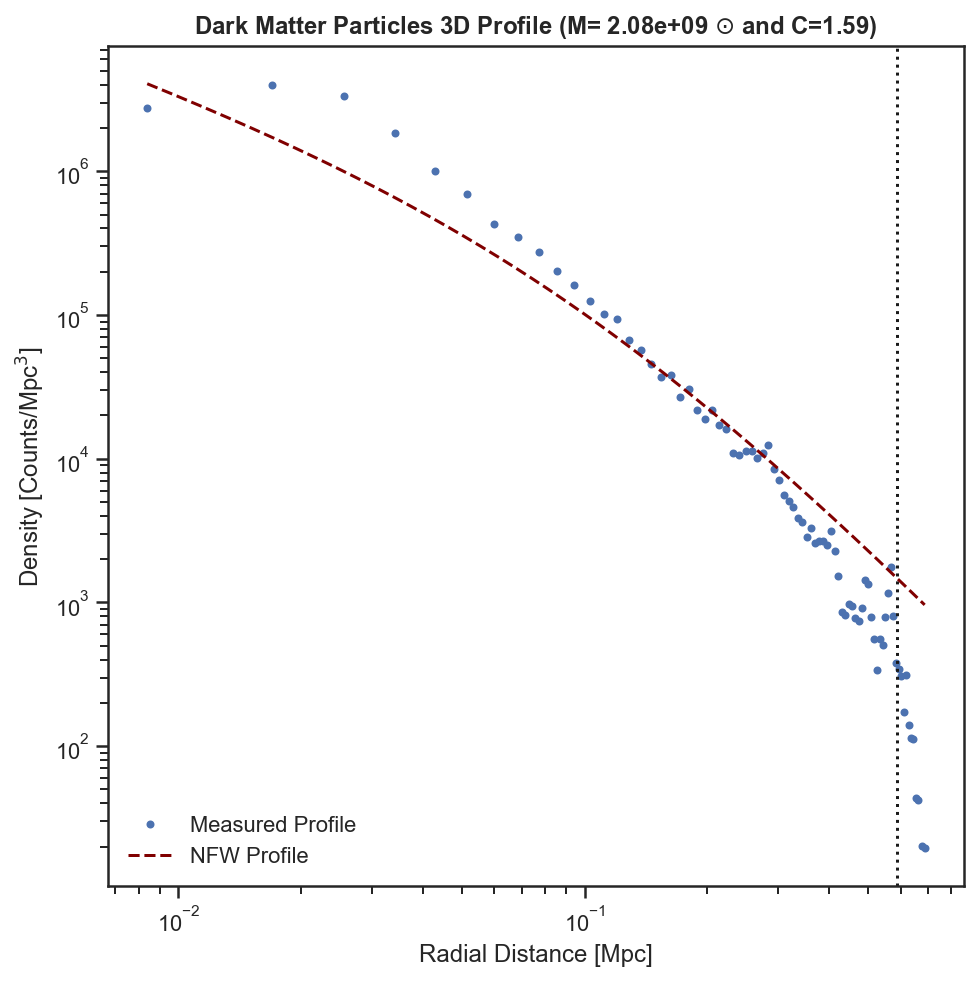

In [27]:
halo = HALO_PROFILE(halo_grp, halo_ind=900)

halo.recompute_profiles(80)
# Determine optimal concentration

def chi_2_NFW(c, input_halo):
    
    # Get profile measurement of halo
    r, rho_true = input_halo.dm_3d_profile[0:2]
    
    # Compute nfw profile
    p_nfw = profile_nfw.NFWProfile(M = input_halo.halo_M_Crit200/conv_fac, 
                                   c = c, z = redshift, mdef = '200c')
    rho_nfw = p_nfw.density(r/conv_fac)
 
    return np.sum((rho_nfw-rho_true)**2)
    
res = scipy.optimize.minimize(chi_2_NFW, x0=[5], args=halo)

c_opt = res.x

# Determine r range for nfw computation
r_min = np.log10(np.min(halo.dm_3d_profile[0]))
r_max = np.log10(np.max(halo.dm_3d_profile[0]))
r = np.logspace(r_min, r_max, 1000)/conv_fac
# Compute profile

z = redshift
p_nfw = profile_nfw.NFWProfile(M = halo.halo_M_Crit200/conv_fac, 
                               c = c_opt, z = z, mdef = '200c')
rho_nfw = p_nfw.density(r)

plt.figure(figsize=(7,7))
plt.plot(halo.dm_3d_profile[0], halo.dm_3d_profile[1],'.', 
         label="Measured Profile")
plt.axvline(halo.R_mean_200, color="k", linestyle=":")

plt.plot(r*conv_fac, rho_nfw, '--', 
         color="Maroon", label = 'NFW Profile')

halo_mass = halo_grp['GroupMass'][halo_ind]*10**10*conv_fac
plt.title("Dark Matter Particles 3D Profile"+ 
          r" (M= {:.2e} $\odot $ and C={:.2f})".format(halo_mass, c_opt[0]), 
          fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel("Density [Counts/Mpc$^3$]")

# Add halo parameters
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

##### **Fit gNFW Profile:**
Fit gNFW profile to the gas density profile.

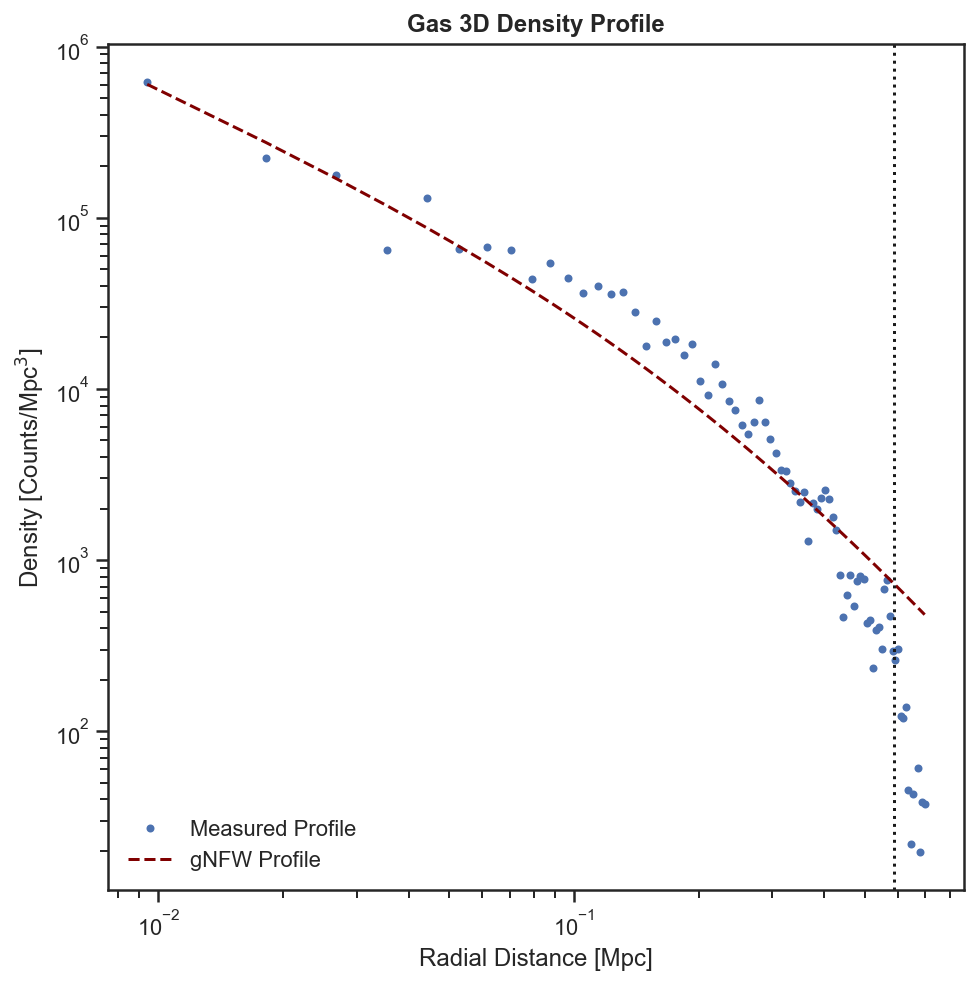

In [7]:
def g_nfw(params, r):
    
    # Unpack parameters
    rho_0, r_s, beta = params
    
    return rho_0/((r/r_s)**beta*(1+r/r_s)**(3-beta))

def chi_2_gNFW(params, input_halo):
    
    # Get profile measurement of halo
    r, rho_g_true = halo.gas_3d_profile
    
    rho_g_nfw = g_nfw(params, r)
    
    return np.sum((rho_g_nfw-rho_g_true)**2)
    
res = scipy.optimize.minimize(chi_2_gNFW, x0=[1000000,0.003,0.9], method = "Nelder-Mead", args=halo)

opt_params = res.x

plt.figure(figsize=(7,7))
plt.plot(halo.gas_3d_profile[0], halo.gas_3d_profile[1], '.', label="Measured Profile")
plt.plot(halo.gas_3d_profile[0], g_nfw(opt_params, halo.gas_3d_profile[0]),'--', 
         color="Maroon", label="gNFW Profile")

plt.axvline(halo_R_Mean200, color="k", linestyle=":")
plt.title("Gas 3D Density Profile", fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel(r"Density [Counts/Mpc$^3$]")
plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)

plt.tight_layout()

##### **Average Density Profiles in Mass Bins:**

In [40]:
halo_indices = np.flip(np.argsort(halo_grp['GroupMass']))[0:1000]
m_Crit200_total = 0
halo_R_mean_200_total = 0

r_full = np.array([], dtype = int)
rho_full = np.array([], dtype = int)

for halo_ind in halo_indices:
    
    assert(halo_ind >= 0 and halo_ind < halo_grp['count']) 

    # Load associated halo profile object
    halo_profile = HALO_PROFILE(halo_grp, halo_ind)
    r = halo_profile.dm_3d_profile[0]
    rho = halo_profile.dm_3d_profile[1]
    
    r_full = np.append(r_full, r/halo.R_mean_200)
    rho_full = np.append(rho_full, rho)
    m_Crit200_total += halo_profile.halo_M_Crit200
    halo_R_mean_200_total += halo.R_mean_200

r_full *= halo_R_mean_200_total/len(halo_indices)

# Compute average profile 
averaged_rho, averaged_r, binnumbers = scipy.stats.binned_statistic(r_full, rho_full, 'mean', bins=80)

# Compute average wave number of each bin
averaged_r = averaged_r+(averaged_r[1]-averaged_r[0])/2
averaged_r = averaged_r[:-1]

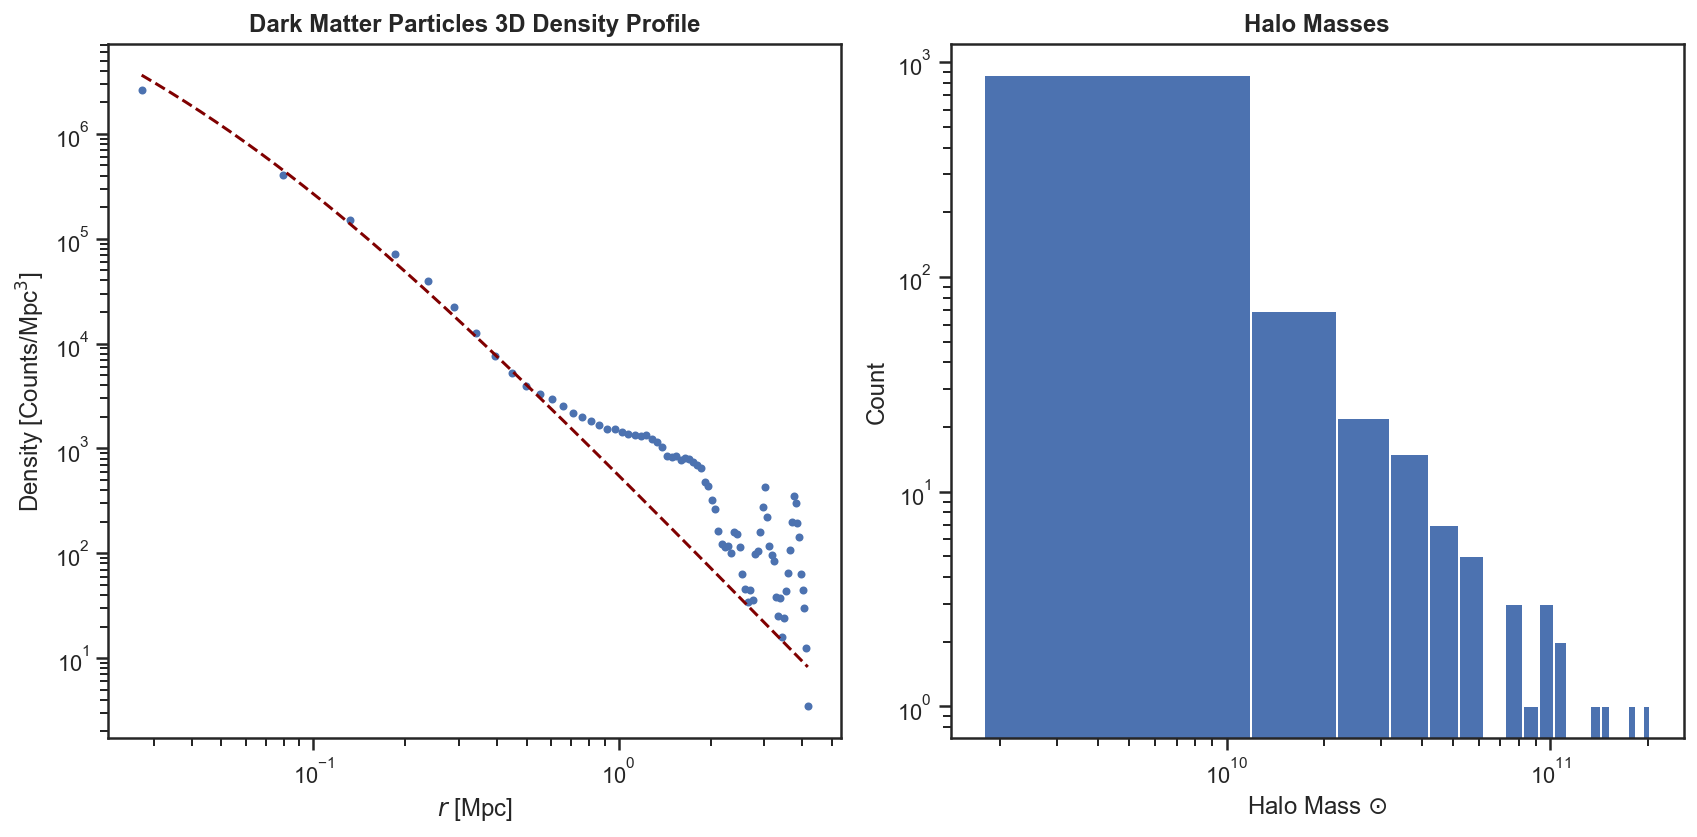

In [41]:
# Compute NFW Profile
m_bar = m_Crit200_total/len(halo_indices)
cvir = concentration.concentration(m_bar/conv_fac, mdef = '200c', z=redshift, model = 'bullock01')
p_nfw = profile_nfw.NFWProfile(M = m_bar/conv_fac, 
                               c = cvir, z=redshift, mdef = '200c')

r_nfw = np.logspace(np.log10(np.min(averaged_r)), 
                    np.log10(np.max(averaged_r)), 1000)/conv_fac
rho_nfw = p_nfw.density(r_nfw)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(averaged_r, averaged_rho, '.')
plt.plot(r_nfw*conv_fac, rho_nfw, '--', 
         color="Maroon", label = 'NFW Profile');
plt.title("Dark Matter Particles 3D Density Profile", fontweight="bold")
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel("Density [Counts/Mpc$^3$]")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
plt.hist(halo_grp['GroupMass'][halo_indices]*10**10*conv_fac, bins=20)
plt.title("Halo Masses", fontweight="bold")
plt.xlabel(r"Halo Mass $\odot$")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

plt.savefig("halo_3d_dm_profile_avg.png", dpi = 250)